Импорт библиотек

In [1]:
from typing import Optional, Tuple, Literal, Iterable
from abc import abstractmethod, ABC
import copy
import torch
from torch import Tensor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from src.nn import BayesianModule, BayesianLinear, BayesianSequential, BayesianBinaryClassifier


def gini_score(
    y_true,
    y_score,
) -> np.float64:
    return (roc_auc_score(y_true=y_true, y_score=y_score) - 0.5) * 2

Чтение данных и разбиение на трейн и тест

In [2]:
df = pd.read_csv("data/Cancer_Data.csv").set_index("id")
df = df.loc[:, df.notna().all(axis=0)]
df["is_M"] = (df["diagnosis"] == "M").astype("int")
df = df.drop("diagnosis", axis=1)
x = df.drop("is_M", axis=1)
y = df["is_M"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

Обучение модели

In [3]:
x_train_tensor = torch.from_numpy(x_train.values).float().cuda()
y_train_tensor = torch.from_numpy(y_train.values).view(-1, 1).float().cuda()

In [4]:
model = BayesianBinaryClassifier(
    dim_in=x_train.shape[-1],
    dims_hidden=[30]*3,
    f_act="ELU",
    backbone="Perceptrone",
    batch_norm=True,
    batch_penalty=True,
).cuda()

epoch
0      34746.484375
1      11551.131836
2       2845.556152
3       1557.998413
4       2425.489502
           ...     
295        0.160145
296        0.160324
297        0.177413
298        0.187145
299        0.174173
Name: kl, Length: 300, dtype: float64

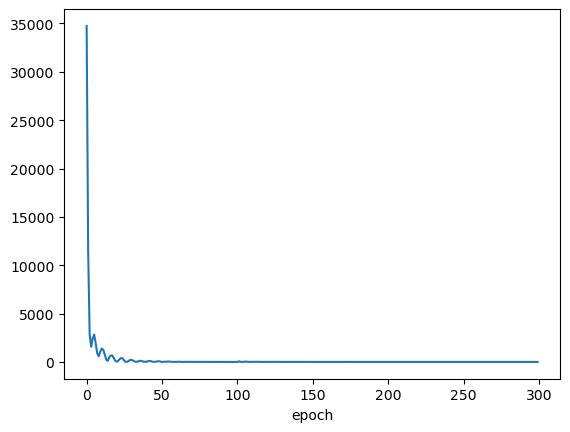

In [5]:
model.init(
    x=x_train_tensor,
    num_epoch=100,
    lr=1,
)
model.init(
    x=x_train_tensor,
    num_epoch=100,
    lr=0.1,
)
model.init(
    x=x_train_tensor,
    num_epoch=100,
    lr=0.01,
)
model.df_metrics["kl"].plot()
model.df_metrics["kl"].dropna()

,kl,loss,p_item_average
epoch,,,
0,34746.484375,NaN,NaN
1,11551.131836,NaN,NaN
2,2845.556152,NaN,NaN
3,1557.998413,NaN,NaN
4,2425.489502,NaN,NaN
...,...,...,...
20295,NaN,0.118612,0.888152
20296,NaN,0.106118,0.899319
20297,NaN,0.129328,0.878686


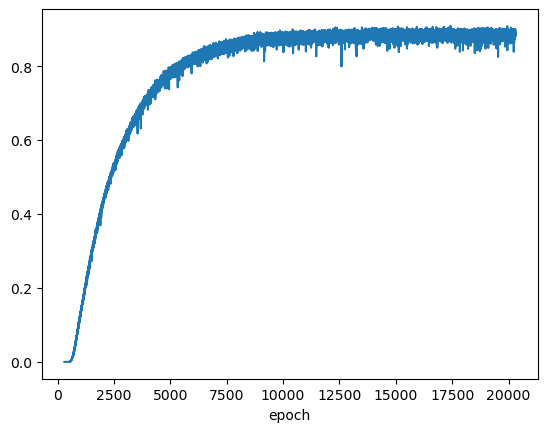

In [6]:
# model.fit(
#     x=x_train_tensor,
#     y=y_train_tensor,
#     num_epoch=1_000,
#     lr=0.05,
# )
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=20_000,
    lr=0.01,
)
# model.fit(
#     x=x_train_tensor,
#     y=y_train_tensor,
#     num_epoch=1_000,
#     lr=0.005,
# )
# model.fit(
#     x=x_train_tensor,
#     y=y_train_tensor,
#     num_epoch=1_000,
#     lr=0.001,
# )
# model.fit(
#     x=x_train_tensor,
#     y=y_train_tensor,
#     num_epoch=1_000,
#     lr=0.0001,
# )
model.df_metrics["p_item_average"].plot()
model.df_metrics

Предсказание на тесте.
Каждый объект прогоняется через модель 5000

In [7]:
model = model.eval().cpu()
x_test_tensor = torch.from_numpy(x_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).view(-1, 1).float()

y_pred_test_tensor = torch.nn.Sigmoid()(model(x_test_tensor.expand(5000, *x_test_tensor.shape)))
y_pred_test = y_pred_test_tensor.cpu().detach().numpy()

Оценка результата работы на тесте

In [8]:
accuracy_score(
    y_true=y_test.values,
    y_pred=y_pred_test.mean(axis=0).reshape(-1) > 0.5,
)

0.956140350877193

Сравнение модели со случайным лесом

In [59]:
model_forest = RandomForestClassifier(n_estimators=500)
model_forest.fit(X=x_train, y=y_train)
y_pred_test_forest = model_forest.predict(X=x_test)

accuracy_score(
    y_true=y_test.values,
    y_pred=model_forest.predict(X=x_test),
)

0.956140350877193

Сравнение модели с бустингом

In [ ]:
model_boost = GradientBoostingClassifier()
model_boost.fit(X=x_train, y=y_train)

accuracy_score(
    y_true=y_test.values,
    y_pred=model_boost.predict(X=x_test),
)

np.float64(0.9955541441727533)

Сравнение модели с перцептроном

In [ ]:
model_mlp = MLPClassifier(hidden_layer_sizes=[30] * 3, activation="relu", max_iter=1000)
model_mlp.fit(X=x_train, y=y_train)

accuracy_score(
    y_true=y_test.values,
    y_pred=model_mlp.predict(X=x_test),
)

np.float64(1.0)